# TODOs:

* write code nicely and comment it
* check marginalization

In [60]:
# Import packages

#builtins
import itertools
from functools import reduce, cache, partial

#essentials
import numpy as np
import matplotlib.pyplot as plt
import h5py #to open data packs
import torch as tr

#non-essentials
from tqdm import tqdm # to show progressbars
tqdm = partial(tqdm, position=0, leave=True)

In [61]:
# Quantum mechanics helper functions and constants
# This has been in KetSugar.py, but it is moved here 
# for transparency.
# ------------------------------------

LO = np.array([[1],[0]])
HI = np.array([[0],[1]])
HLO = (LO+HI)*(2**-.5)
HHI = (LO-HI)*(2**-.5)
CLO = (LO+1j*HI)*(2**-.5)
CHI = (LO-1j*HI)*(2**-.5)

Sgate = np.array([[1, 0], [0, 1j]])
SI = np.eye(2)
SZ = np.diag([1,-1])
SX = np.array([[0,1],[1,0]])
SY = np.array([[0,-1j],[1j,0]])

#eigenvectors and eigenvalues of Pauli matrices
PAULI_EIGENBASE_DICT = {
    'I' : ((LO, HI), (1,1)),
    'X' : ((HLO, HHI), (1,-1)),
    'Y' : ((CLO, CHI),(1,-1)),
    'Z' : ((LO, HI), (1,-1)),
}

def dagger(x : np.ndarray) -> np.ndarray:
    """
    Hermite conjugation of x.
    """
    return x.T.conjugate()

def ketbra(x : np.ndarray, y : np.ndarray) -> np.ndarray:
    """
    Outer product of two ket-vectors -> C-matrix
    """
    return np.dot(x, y.T.conjugate())

def kron(*arrays) -> np.ndarray:
    """
    Multiple Kronecker (tensor) product.
    Multiplication is performed from left.    
    """
    E = np.eye(1, dtype=complex)
    for M in arrays:
        E = np.kron(E,M)
    return E

def BinKet(i : int = 0,imx : int =1) -> np.ndarray:
    """
    Computational base states i in imx+1-dimensional vectors.
    """
    ket = np.zeros((imx+1,1), dtype=complex)
    ket[i] = 1
    return ket

def ApplyOp(Rho : np.ndarray,M : np.ndarray) -> np.ndarray:
    """
    Calculate M.Rho.dagger(M).
    """
    return M @ Rho @ M.T.conjugate()

def ExpectationValue(Ket : np.ndarray, M : np.ndarray) -> np.ndarray:
    """
    Expectation value <bra|M|ket>.
    """
    return (Ket.T.conjugate() @ M @ Ket)[0,0]

@cache
def get_walsh_hadamard_vec(label : str) -> np.ndarray:
    """
    Get auxiliary vector for turning tomogram row into expectation value. Candidate for tabellation.
    """
    #eigenvalues of Pauli operators
    arr_map = {
        'X' : np.array([1,-1]),
        'Y' : np.array([1,-1]),
        'Z' : np.array([1,-1]),
        'I' : np.array([1,1])
    }
    return reduce(np.outer, [arr_map.get(c, np.eye(1)) for c in label]).ravel()
get_walsh_hadamard_vec.cache_clear()

@cache #cache calls to r
def base_string_to_proj(string : str) -> list:
    """
    Input measurement string and get projection operators corresponding to that string, 
    all combinations that can happen.    
    """    
    eigenvects = [PAULI_EIGENBASE_DICT[b][0] for b in string]
    proj_kets = [kron(*vecs) for i, vecs in enumerate(itertools.product(*eigenvects))]
    return proj_kets
base_string_to_proj.cache_clear()

def get_probabilities(rho : np.ndarray, base_str : str) -> np.ndarray:
    """Input density matrix and measurement string, and get array of probabilities ordered from 0..0 to 1..1"""
    #probs are ordered in increasing order of their binary representation
    probs = np.array([ExpectationValue(ket, rho).real for ket in base_string_to_proj(base_str)])
    return probs

In [62]:
# Define the states considered here
# ---------------------------
#Swap gates
def swap_ij(n : int, i : int, j : int) -> np.ndarray:
    """Generate swap matrix of qubits i,j in n-qubit space."""
    left_qubits = i
    central_qubits = (j - i) - 1
    right_qubits = (n - j) - 1
    eye_left = np.eye(1 << left_qubits)
    eye_center = np.eye(1 << central_qubits)
    eye_right = np.eye(1 << right_qubits)    
    ket_01 = kron(eye_left, LO, eye_center, HI, eye_right)
    ket_10 = kron(eye_left, HI, eye_center, LO, eye_right)
    bra_01 = dagger(ket_01)
    bra_10 = dagger(ket_10)
    swap = np.eye(1 << n, dtype=complex) \
        - ket_01 @ bra_01 - ket_10 @ bra_10 \
        + ket_01 @ bra_10 + ket_10 @ bra_01
    return swap

#operator that does this swap: abcabc -> aabbcc
swap_abc = swap_ij(6,3,4) @ swap_ij(6,1,2) @ swap_ij(6,2,3)

prep_gate = kron(Sgate, Sgate, SZ)
bellp = (BinKet(0b00, 3) + BinKet(0b11, 3))/np.sqrt(2)
bellm = (BinKet(0b00, 3) - BinKet(0b11, 3))/np.sqrt(2)
bell02p = (BinKet(0b000, 7) + BinKet(0b101, 7)+BinKet(0b010, 7) + BinKet(0b111, 7))/2
bell02m = (BinKet(0b000, 7) - BinKet(0b101, 7)-BinKet(0b010, 7) + BinKet(0b111, 7))/2

#single-copy constituent states as ket vectors
theo_kets_3q = {
    'a1' : kron(HLO, bellp),
    'a2' : kron(HHI, bellm),
    'a3' : prep_gate @ kron(HLO, bellp),
    'a4' : prep_gate @ kron(HHI, bellm),
    'b1' : bell02p,
    'b2' : bell02m,
    'b3' : prep_gate @ bell02p,
    'b4' : prep_gate @ bell02m,
    'c1' : BinKet(0b001, 7),
    'c2' : BinKet(0b110, 7)
}

#single-copy constituent states as density matrices
theo_rhos_3q = {key : ketbra(ket, ket) for key, ket in theo_kets_3q.items()}
theo_kets_6q = {
    f'{key1},{key2}' :
    kron(theo_kets_3q.get(key2), theo_kets_3q.get(key1)) 
    for key1, key2 in itertools.product(theo_kets_3q.keys(), repeat=2)}

#two-copy constituent states
theo_rhos_6q = {key : ketbra(ket, ket) for key, ket in theo_kets_6q.items()}
theo_rhos_6q_swapped = {key : ApplyOp(rho, swap_abc) for key, rho in theo_rhos_6q.items()}

key_order = list(theo_rhos_6q_swapped.keys())

Q = 0.26 #absurd value, normal would be 0.05
weights_single_copy = np.array([(1-Q)/8]*8 + [Q/2]*2)

weights_two_copy = np.outer(weights_single_copy,weights_single_copy).ravel()
# # equivalent to
# def key_to_weight(key):
#     n = key.count('c')
#     if n==0:
#         return ((1-Q)**2)/64
#     if n==1:
#         return ((1-Q)*Q)/(8*2)
#     if n==2:
#         return Q*Q/4

In [63]:
with h5py.File('data/wits.h5', 'r') as h5f:
    witness_measurements = [s.decode('ascii') for s in h5f['two_copy_table_meas']]
    witness_full_meas = [s.decode('ascii') for s in h5f['two_copy_table_meas_full']] #h5f['two_copy_table_meas_full']
    witness_factors = np.array(h5f['two_copy_table_factors'])
    witness_op = np.array(h5f['two_copy_operator'])

#table of vectors used to convert tomogram lines to expectation values
walsh_table = np.array([get_walsh_hadamard_vec(m) for m in witness_full_meas])

def extend_tomogram(tomo : np.ndarray) -> np.ndarray:
    """
    Copy first line of the tomogram 16-times.
    This is only a helper function to make the subsequent 
    calculations more convenient.
    It will be used to predict exp. values of measurements containing only I and Z.
    """
    return np.array([tomo[0]]*16 + list(tomo[1:]))


In [64]:
witness_measurements

['ZZZZZZ',
 'XXXXXX',
 'YXYXXX',
 'XYXYXX',
 'YYYYXX',
 'YXXXYX',
 'XXYXYX',
 'YYXYYX',
 'XYYYYX',
 'XYXXXY',
 'YYYXXY',
 'XXXYXY',
 'YXYYXY',
 'YYXXYY',
 'XYYXYY',
 'YXXYYY',
 'XXYYYY']

In [65]:
# np.genfromtxt('witness_3copy_table.txt').shape
import pandas as pd

dframe = pd.read_csv('witness_3copy_table.txt', sep='\t')

In [66]:
dframe.keys()

Index(['#ID ', ' MEAS ', ' k ', ' weight'], dtype='object')

In [67]:
mstrs3cpy = [m.replace(' ','')[::-1] for m in dframe[' MEAS '][63:]]
fullmstrs3cpy = [m.replace(' ','')[::-1] for m in dframe[' MEAS ']]
mstrs3cpy[0] = 'Z'*9
wwghst3cpy = np.array(dframe[' weight'])

In [68]:
#extend 0.333 to 0.333... to compensate for the rounding in saved table
for i, w in enumerate(wwghst3cpy):
    if (abs(w)-0.333) < 1e-3:
        wwghst3cpy[i] = np.sign(w)*1/3

In [69]:
mstrs3cpy[-1], witness_measurements[-1]

('XXXYYYYYY', 'XXYYYY')

In [70]:
mstrs3cpy

['ZZZZZZZZZ',
 'XXXXXXXXX',
 'YXXYXXXXX',
 'XYXXYXXXX',
 'YYXYYXXXX',
 'XXYXXYXXX',
 'YXYYXYXXX',
 'XYYXYYXXX',
 'YYYYYYXXX',
 'YXXXXXYXX',
 'XXXYXXYXX',
 'YYXXYXYXX',
 'XYXYYXYXX',
 'YXYXXYYXX',
 'XXYYXYYXX',
 'YYYXYYYXX',
 'XYYYYYYXX',
 'XYXXXXXYX',
 'YYXYXXXYX',
 'XXXXYXXYX',
 'YXXYYXXYX',
 'XYYXXYXYX',
 'YYYYXYXYX',
 'XXYXYYXYX',
 'YXYYYYXYX',
 'YYXXXXYYX',
 'XYXYXXYYX',
 'YXXXYXYYX',
 'XXXYYXYYX',
 'YYYXXYYYX',
 'XYYYXYYYX',
 'YXYXYYYYX',
 'XXYYYYYYX',
 'XXYXXXXXY',
 'YXYYXXXXY',
 'XYYXYXXXY',
 'YYYYYXXXY',
 'XXXXXYXXY',
 'YXXYXYXXY',
 'XYXXYYXXY',
 'YYXYYYXXY',
 'YXYXXXYXY',
 'XXYYXXYXY',
 'YYYXYXYXY',
 'XYYYYXYXY',
 'YXXXXYYXY',
 'XXXYXYYXY',
 'YYXXYYYXY',
 'XYXYYYYXY',
 'XYYXXXXYY',
 'YYYYXXXYY',
 'XXYXYXXYY',
 'YXYYYXXYY',
 'XYXXXYXYY',
 'YYXYXYXYY',
 'XXXXYYXYY',
 'YXXYYYXYY',
 'YYYXXXYYY',
 'XYYYXXYYY',
 'YXYXYXYYY',
 'XXYYYXYYY',
 'YYXXXYYYY',
 'XYXYXYYYY',
 'YXXXYYYYY',
 'XXXYYYYYY']

In [71]:
mstrs_red = [m[0]+m[2]+m[4] for m in witness_measurements]

def can_be_composed(m):
    pt1 = m[0]+m[1]+m[3]+m[4]+m[6]+m[7]
    pt2 = m[2]+m[5]+m[8]
    cnd = (pt1 in witness_measurements) and (pt2 in mstrs_red)
    
    i = witness_measurements.index(pt1)
    j = mstrs_red.index(pt2)
    return cnd, i, j

for m in mstrs3cpy:
    cnd, i, j = can_be_composed(m)
    assert cnd
    
#obs: all needed lines can composed

In [72]:
#create marginal tomogram by picking 

with h5py.File('data/wit_data_27_05_25_Block2.h5', 'r') as h5f:
    measd_keys = h5f.attrs.get('prepared_states')
    #load H5 file into dict of tomograms
    measd_tomogram = {key : np.array(h5f[key]) for key in key_order}
measd_tomogram_arr = np.array([measd_tomogram[key] for key in key_order])
measd_tomogram_arr.shape    

(100, 17, 64)

In [73]:
measd_tomogram_arr[0].shape

(17, 64)

In [74]:
def get_reduction_vec(nbits, picked_bits = None):
    """Go through all n-bit values and calculate corresponding reduced number by picking bits."""
    vec = []
    for i in range(int(2**nbits)):
        ired = 0
        for j, p in enumerate(picked_bits):
            bit_value = bool(((0b1 << p) & i))
            ired |= (bit_value << j)
        vec.append(ired)
    return vec

def marginalize_tomo(tomo, picked_bits):
    """
    Marginalize a tomogram over a subset of bits.

    Parameters
    ----------
    tomo : np.ndarray
        The input tomogram array of shape (n, 2**k), where k is the number of bits.
    picked_bits : list or None
        List of bit indices to keep (marginalize over all other bits).
    Returns
    -------
    arr : np.ndarray
        The marginalized tomogram of shape (n, 2**len(picked_bits)).
    """
    n, m = tomo.shape
    original_bit_length = int(np.log2(m))
    new_arr_length = int(2**len(picked_bits))
    idxvec = np.array(get_reduction_vec(original_bit_length, picked_bits))
    arr = np.zeros((n, new_arr_length))
    for i in range(new_arr_length):
        subtomo = np.sum(tomo[:, idxvec==i], axis=1)
        arr[:,i] = subtomo
    return arr

In [75]:
subwitness_full_meas = [m[0]+m[2]+m[4] for m in witness_full_meas]

In [76]:
#table of vectors used to convert tomogram lines to expectation values
walsh_table = np.array([get_walsh_hadamard_vec(m) for m in witness_full_meas])
subwalsh_table = np.array([get_walsh_hadamard_vec(m) for m in subwitness_full_meas])

def extend_tomogram(tomo : np.ndarray) -> np.ndarray:
    """
    Copy first line of the tomogram 16-times.
    This is only a helper function to make the subsequent 
    calculations more convenient.
    It will be used to predict exp. values of measurements containing only I and Z.
    """
    return np.array([tomo[0]]*16 + list(tomo[1:]))

In [77]:
Q = 0.26 #0.05
weights_single_copy = np.array([(1-Q)/8]*8 + [Q/2]*2)
weights_two_copy = np.outer(weights_single_copy,weights_single_copy).ravel()

#weight-and-mix the constituent tomograms
weighted_tomo_counts = np.sum(measd_tomogram_arr * weights_two_copy.reshape((100,1,1)), axis=0)
#norm lines to identity sum - in order to convert possible count array to probabilities
weighted_tomo_probs = weighted_tomo_counts/np.sum(weighted_tomo_counts, axis=1).reshape((17,1))
#extend tomogram by copying the first line 16-times to...
wtomo2cpy = extend_tomogram(weighted_tomo_probs)

expvals2cp = np.sum(walsh_table*wtomo2cpy, axis=1)
expvals2cp.shape

(32,)

In [78]:
# expectation value for two qubit is higher than 0 - GME is not certified
expvals2cp @ witness_factors

0.13623724999999953

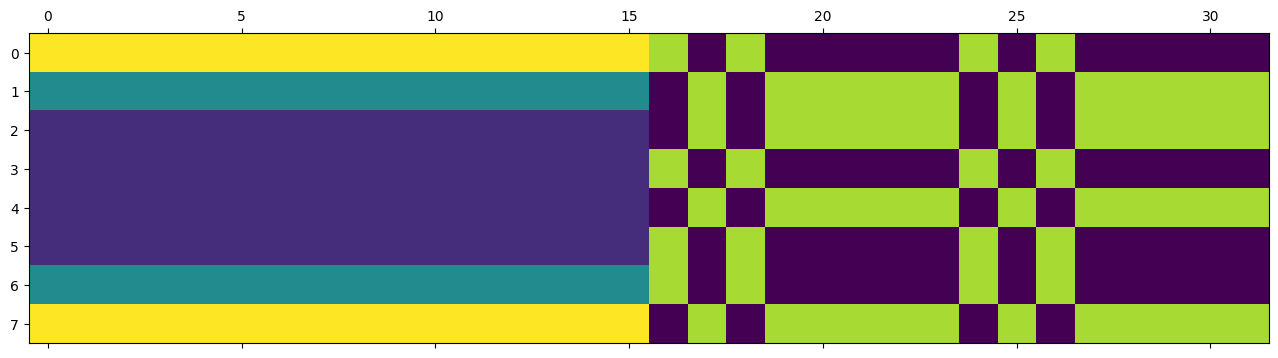

In [79]:
rth0 = theo_rhos_3q['a1'] + theo_rhos_3q['a2']  + theo_rhos_3q['a3'] + theo_rhos_3q['a4']
rth0 += theo_rhos_3q['b1'] + theo_rhos_3q['b2']  + theo_rhos_3q['b3'] + theo_rhos_3q['b4']
rth0 /= 8
rth0 = rth0*(1-Q) + Q*(theo_rhos_3q['c1'] + theo_rhos_3q['c2'])/2

gen = (get_probabilities(rth0, m) for m in subwitness_full_meas)
theoretical_tomogram_red = np.array(list(gen)).reshape((-1,8))
plt.matshow(theoretical_tomogram_red.T)

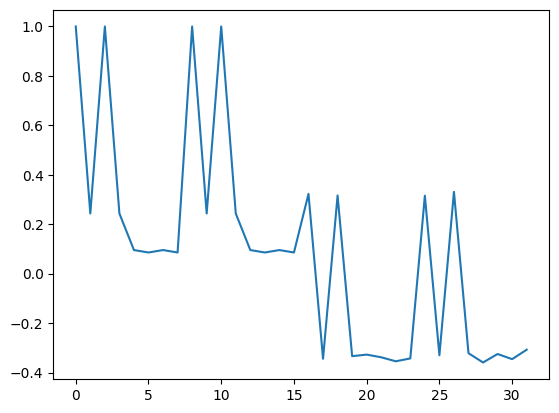

In [80]:
# wtm1 = marginalize_tomo(wtomo2cpy, [0,2,4]) #strange...check this
reduced_mixed_wit_tomo = marginalize_tomo(wtomo2cpy, [1,3,5])
reduced_expvals = np.sum(subwalsh_table * reduced_mixed_wit_tomo, axis=1)

plt.plot(reduced_expvals)

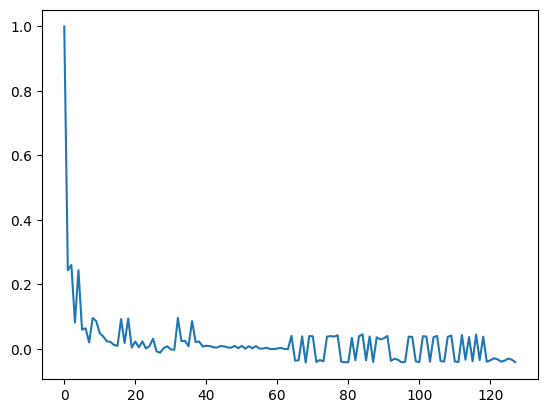

In [81]:
#measurements on the first copy
mstrs_red2 = [m[0]+m[2]+m[4] for m in witness_full_meas]

def can_be_composed2(m):
    pt1 = m[0]+m[1]+m[3]+m[4]+m[6]+m[7] #measurement on first two copies
    pt2 = m[2]+m[5]+m[8] #measurements on the third copy
    cnd = (pt1 in witness_full_meas) and (pt2 in mstrs_red2) #true if the measurement m can be composed from 2-copy subtomos
    
    i = witness_full_meas.index(pt1)
    j = mstrs_red2.index(pt2)
    return cnd, i, j

expvals_extrapolated = []

for m in fullmstrs3cpy:
    ok, i, j = can_be_composed2(m)
    assert ok
    pt1 = expvals2cp[i]
    pt2 = reduced_expvals[j]
    tot = pt1 * pt2
    expvals_extrapolated.append(tot)

expvals_extrapolated = np.array(expvals_extrapolated)
expvals_extrapolated.shape
plt.plot(expvals_extrapolated)

In [82]:
swap_9q = swap_ij(9,5,7) @ swap_ij(9, 2,6) @ swap_ij(9, 1,3)
rth3cpy = ApplyOp(kron(rth0, rth0, rth0), swap_9q)

In [83]:
tomo3cpy = np.array([get_probabilities(rth3cpy, m) for m in fullmstrs3cpy])

In [84]:
walsh3cpy = np.array([get_walsh_hadamard_vec(m) for m in fullmstrs3cpy])

In [85]:
expvalth_3cpy = np.sum(tomo3cpy * walsh3cpy, axis=1)
wval3th = wwghst3cpy @ expvalth_3cpy
print(wval3th)

-0.43549333333333384


In [86]:
wval3extrp = wwghst3cpy @ expvals_extrapolated
print(wval3extrp)

-0.13204261748025103


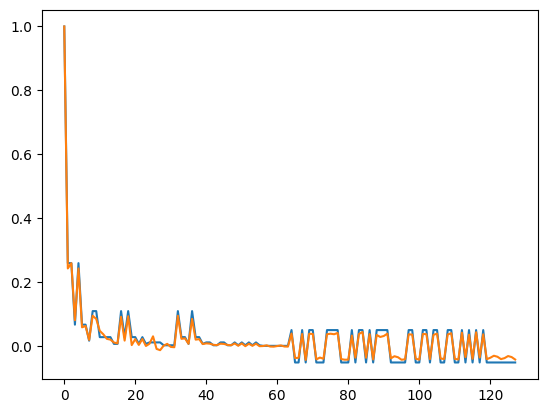

In [87]:
plt.plot(expvalth_3cpy)
plt.plot(expvals_extrapolated)

In [88]:
## Predict the value based on reconstructed density matrices

with h5py.File('data/new_single_copy_states.h5', 'r') as h5:
    rhos_first_copy = np.array(h5['rhos024'])
    rhos_second_copy = np.array(h5['rhos531'])
    rho_first = np.sum(rhos_first_copy * weights_single_copy.reshape((-1,1,1)), axis=0)
    rho_second = np.sum(rhos_second_copy * weights_single_copy.reshape((-1,1,1)), axis=0)
    rhos_third_copy = rhos_first_copy #(rhos_first_copy + rhos_second_copy)/2
    #since we do not know, we take a mean
    rho_third = (rho_first+rho_second)*0.5

rho_extrapolated_3cpy = kron(rho_first, rho_second, rho_third)

rho_extr_3cpy_sw = (swap_9q @ rho_extrapolated_3cpy @ swap_9q)

In [89]:
import KetSugar as ks
ks.Fidelity(rho_extr_3cpy_sw, rth3cpy)
#theoretical to expolated state fidelity

0.9543167960681679

In [90]:
theo_rhos_3q_list = [theo_rhos_3q[key] for key in [f'a{i}' for i in range(1,5)]+[f'b{i}' for i in range(1,5)]+['c1','c2']]

### Create probability tables for ideal states

In [91]:
#simulate witness tomogram - with ideal states
# get_probabilities(rho_extr_3cpy_sw, fullmstrs3cpy[0])
# big_prob_table = np.zeros((1000, 128, 512))

# #this the idea, but these loop on CPU in python are slow
# #instead we do vectorization and run it using torch
# for (i, j, k) in tqdm(itertools.product(range(10), repeat=3), total=1000):
#     _big_index = (i*100 + j*10 + k)
#     _rho = kron(rhos_first_copy[i], rhos_first_copy[j], rhos_first_copy[k])
#     for l, m in enumerate(fullmstrs3cpy):
#         big_prob_table[_big_index, l, :] = get_probabilities(_rho, m)     
# np.save('_prob_table_cache.npy', big_prob_table)

with tr.no_grad():        
    # big_prob_table = np.zeros((1000, len(fullmstrs3cpy), 512), dtype=np.float32) #~500 MB
    big_prob_table_gpu_ideal = tr.zeros((1000, len(fullmstrs3cpy), 512), dtype=tr.float64, device='cuda')
    big_state_table_gpu_ideal = tr.zeros((1000, 512*512), dtype=tr.complex128, device='cuda')

    #prepare individual density matrices into a nice linearized table
    for (_i, _j, _k) in tqdm((itertools.product(range(10), repeat=3)), total=1000):
        _big_index = (_i*100 + _j*10 + _k)
        _rho = ApplyOp(kron(theo_rhos_3q_list[_i], theo_rhos_3q_list[_j], theo_rhos_3q_list[_k]), swap_9q)
        big_state_table_gpu_ideal[_big_index, :] = tr.from_numpy(_rho.ravel())

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.03it/s]


In [92]:
with tr.no_grad():   
    for mindex, mstring in tqdm(enumerate(fullmstrs3cpy), total=128):
        # print(mindex, mstring)
        #generate projection table    
        _proj_table = np.zeros((512*512,512), dtype=np.complex128) #2 GB of memory if using complex128
        #this is slow and could be optimized further, but meh
        for _i, ket in enumerate(base_string_to_proj(mstring)):
            _proj_table[:,_i] = (ket @ ket.T.conj()).T.ravel()
        _proj_table_gpu = tr.from_numpy(_proj_table).cuda()
        #and use it to predict probabilities on rho
        big_prob_table_gpu_ideal[:,mindex,:] = tr.matmul(big_state_table_gpu_ideal, _proj_table_gpu).real

del big_state_table_gpu_ideal

big_prob_table_cpu_ideal =  big_prob_table_gpu_ideal.cpu().numpy()
np.save('_cached_big_prob_table_ideal.npy', big_prob_table_cpu_ideal)    

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [06:16<00:00,  2.94s/it]


In [93]:
del big_prob_table_gpu_ideal

In [94]:
big_prob_table_cpu_ideal = np.load('_cached_big_prob_table_ideal.npy')

### Create tables for reconstructed

In [95]:
with tr.no_grad():        
    # big_prob_table = np.zeros((1000, len(fullmstrs3cpy), 512), dtype=np.float32) #~500 MB
    big_prob_table_gpu = tr.zeros((1000, len(fullmstrs3cpy), 512), dtype=tr.float64, device='cuda')
    big_state_table_gpu = tr.zeros((1000, 512*512), dtype=tr.complex128, device='cuda')

    #prepare individual density matrices into a nice linearized table
    for (_i, _j, _k) in tqdm((itertools.product(range(10), repeat=3)), total=1000):
        _big_index = (_i*100 + _j*10 + _k)
        _rho = ApplyOp(kron(rhos_first_copy[_i], rhos_first_copy[_j], rhos_third_copy[_k]), swap_9q)
        big_state_table_gpu[_big_index, :] = tr.from_numpy(_rho.ravel())

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.05it/s]


In [96]:
with tr.no_grad():   
    for mindex, mstring in tqdm(enumerate(fullmstrs3cpy),total=128):
        # print(mindex, mstring)
        #generate projection table    
        _proj_table = np.zeros((512*512,512), dtype=np.complex128)
        #this is slow and could be optimized further, but meh
        for _i, ket in enumerate(base_string_to_proj(mstring)):
            _proj_table[:,_i] = (ket @ ket.T.conj()).T.ravel()
        _proj_table_gpu = tr.from_numpy(_proj_table).cuda()
        #and use it to predict probabilities on rho
        big_prob_table_gpu[:,mindex,:] = tr.matmul(big_state_table_gpu, _proj_table_gpu).real

big_prob_table_cpu =  big_prob_table_gpu.cpu().numpy()
del big_state_table_gpu
del big_prob_table_gpu
np.save('_cached_big_prob_table.npy', big_prob_table_cpu)    

100%|█████████████████████████████████████████████████████████████████████████████████| 128/128 [06:19<00:00,  2.96s/it]


In [107]:
np.sum(big_prob_table_cpu[0,0])

1.0000000000000002

In [108]:
weights_tree_copies = (weights_single_copy.reshape((10,1,1)) * weights_single_copy.reshape((1,10,1)) * weights_single_copy.reshape((1,1,10))).ravel()

In [109]:
def selfnorm(arr):
    return arr/np.sum(arr)

def sample_tomogram(shots, table, norm=True):
    new_tomo = np.zeros_like(table, dtype=np.float32)
    for i, subtable in enumerate(table):
        for j, line in enumerate(subtable):
            nline = np.clip(line.astype(np.float64),0,1)
            nline /= np.sum(nline)
            new_tomo[i,j] = np.random.multinomial(shots, nline)        
    if norm:
        new_tomo /= np.sum(new_tomo, axis=2).reshape((table.shape[0], table.shape[1], 1))
    return new_tomo

def process_tomo(tomo):
    wghtd_tomo = np.sum(tomo * weights_tree_copies.reshape((1000,1,1)), axis=0)
    expval = np.sum(wghtd_tomo * walsh3cpy, axis=1)
    return wwghst3cpy @ expval
    

In [100]:
# ideal states, many shots, 1 monte carlo sample
monte_carlo_samples = 1
shots = 512*1000
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu_ideal, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.50s/it]

-0.4351453151726786
0.0
-0.4351453151726786
-0.4351453151726786


In [101]:
# reconstructed states, many shots, 1 monte carlo sample
monte_carlo_samples = 1
shots = 512*1000
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.19s/it]

-0.03559477645337844
0.0
-0.03559477645337844
-0.03559477645337844


In [102]:
# reconstructed states, 50 shots per state and meas, 100 monte carlo sample
monte_carlo_samples = 100
shots = 50
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [07:19<00:00,  4.40s/it]

-0.03308578135662888
0.023054429614512602
-0.09738604468401396
0.017042056964755414


(array([ 1.,  3.,  3., 18., 13., 19., 14., 14., 12.,  3.]),
 array([-0.09738604, -0.08594323, -0.07450042, -0.06305761, -0.0516148 ,
        -0.04017199, -0.02872918, -0.01728637, -0.00584356,  0.00559925,
         0.01704206]),
 <BarContainer object of 10 artists>)

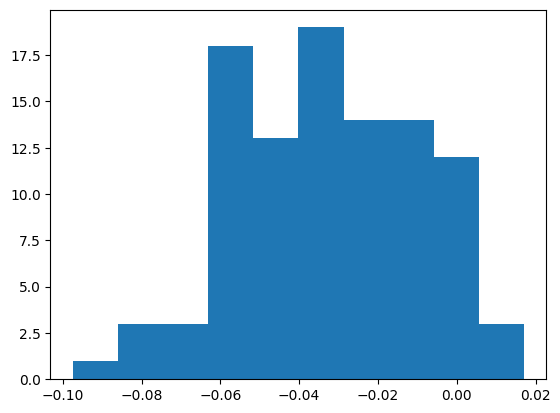

In [103]:
plt.hist(witness_samples)

In [104]:
# reconstructed states, 50 shots per state and meas, 100 monte carlo sample
monte_carlo_samples = 100
shots = 50
witness_samples = np.array([process_tomo(sample_tomogram(shots, big_prob_table_cpu_ideal, True)) for i in tqdm(range(monte_carlo_samples))])
print(np.mean(witness_samples))
print(np.std(witness_samples))
print(np.min(witness_samples))
print(np.max(witness_samples))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.05s/it]

-0.4340506385751842
0.023849144392745755
-0.48964233714173405
-0.3522442598975606


(array([ 4.,  6., 20., 19., 30., 12.,  3.,  3.,  2.,  1.]),
 array([-0.48964234, -0.47590253, -0.46216272, -0.44842291, -0.43468311,
        -0.4209433 , -0.40720349, -0.39346368, -0.37972388, -0.36598407,
        -0.35224426]),
 <BarContainer object of 10 artists>)

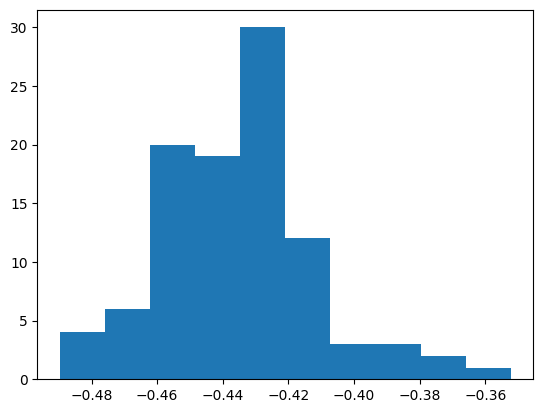

In [105]:
plt.hist(witness_samples)